In [36]:
import pandas as pd
import numpy as np
import requests
import time
import os

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [37]:
class RateLimitError(Exception):
    pass

with open("x_bearer_token.txt", "r") as f:
    bearer_token = f.read().strip()

headers = {
    "Authorization": f"Bearer {bearer_token}"
}

def search_tweets(query, max_results=10, max_retries=5):
    url = "https://api.twitter.com/2/tweets/search/recent"
    params = {
        "query": query,
        "max_results": max_results,
        "tweet.fields": "id,text,lang,created_at"
    }

    retries = 0
    wait_base = 40

    while retries < max_retries:
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            wait = wait_base * (retries + 1)
            print(f"Rate limit! Waiting {wait} seconds.. (retry {retries+1}/{max_retries})")
            time.sleep(wait)
            retries += 1
        else:
            print("Unknown error:", response.status_code)
            return {"data": []}

    raise RateLimitError("Max retries reached. Try again later.")


queries = [
    "donald trump lang:en -is:retweet",
    "donald trump lang:en news -is:retweet",
    "donald trump lang:en clinton -is:retweet",
    "donald trump lang:en epstein -is:retweet",
    "donald trump lang:en election -is:retweet",
    "donald trump lang:en debate -is:retweet",
    "donald trump lang:en speech -is:retweet",
    "donald trump lang:en lawsuit -is:retweet",
    "donald trump lang:en supporters -is:retweet",
    "donald trump lang:en criticism -is:retweet"
]

csv_path = "tweets.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    df = pd.DataFrame()


# if query q already in csv file then skip to the other query
tweets = []

processed_queries = set(df["query"].unique()) if not df.empty else set()

for q in queries:

    if q in processed_queries:
        print(f"Skipped query (already in csv): {q}")
        continue
    
    print(f"\nQuery: {q}")

    data = search_tweets(q)

    if "data" in data:
        for t in data["data"]:
            t["query"] = q 
        tweets.extend(data["data"])
        print(f"Number of new tweets: {len(data['data'])}.")
        break # for rate limit
    else:
        print("No new tweet:", data)
        break

    time.sleep(2)

new_df = pd.DataFrame(tweets)

if not new_df.empty:
    df = pd.concat([df, new_df], ignore_index=True)
    df.drop_duplicates(subset=["id"], inplace=True)
    df.to_csv(csv_path, index=False)

print("\nTotal Records: ", len(df))
print("CSV updated:", csv_path)

Skipped query (already in csv): donald trump lang:en -is:retweet
Skipped query (already in csv): donald trump lang:en news -is:retweet
Skipped query (already in csv): donald trump lang:en clinton -is:retweet
Skipped query (already in csv): donald trump lang:en epstein -is:retweet
Skipped query (already in csv): donald trump lang:en election -is:retweet
Skipped query (already in csv): donald trump lang:en debate -is:retweet
Skipped query (already in csv): donald trump lang:en speech -is:retweet
Skipped query (already in csv): donald trump lang:en lawsuit -is:retweet

Query: donald trump lang:en supporters -is:retweet
Number of new tweets: 10.

Total Records:  100
CSV updated: tweets.csv


# Kaggle Data

### 1 - Exploratory Data Analysis

In [38]:
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
df2 = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                 encoding='latin-1', 
                 names=column_names)

print(f"Total records: {len(df2):,}")
print(f"Columns: {list(df2.columns)}")

Total records: 1,600,000
Columns: ['target', 'ids', 'date', 'flag', 'user', 'text']


In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [40]:
df2.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [41]:
df2['target'].value_counts().sort_index()

target
0    800000
4    800000
Name: count, dtype: int64

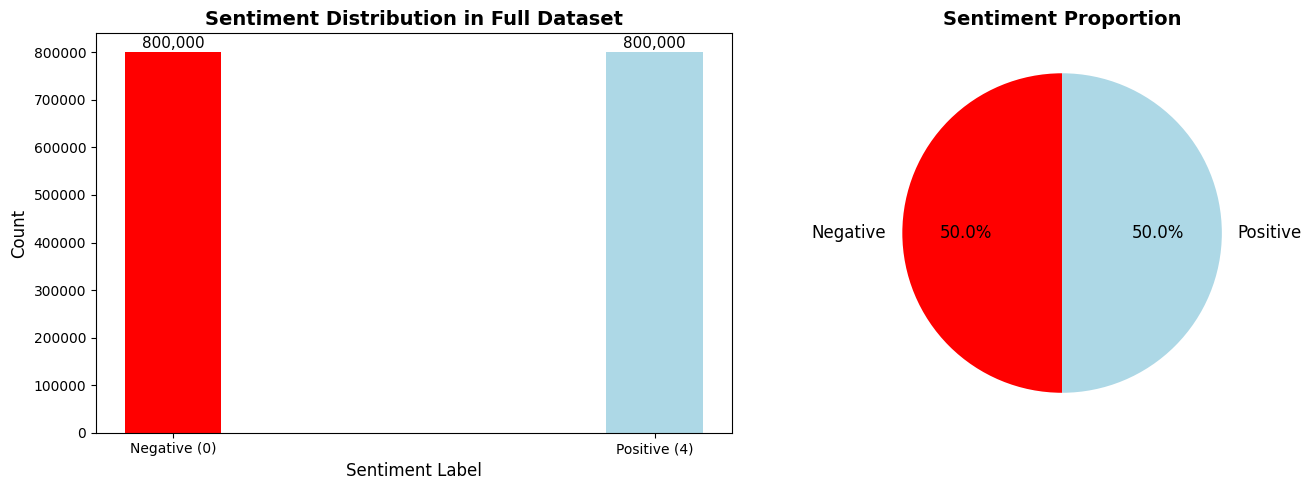

In [42]:
# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
target_counts = df2['target'].value_counts().sort_index()
axes[0].bar(target_counts.index, target_counts.values, color=['red', 'lightblue'])
axes[0].set_xlabel('Sentiment Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Sentiment Distribution in Full Dataset', fontsize=14, fontweight='bold')
axes[0].set_xticks([0, 4])
axes[0].set_xticklabels(['Negative (0)', 'Positive (4)'])
for i, v in enumerate(target_counts.values):
    axes[0].text(target_counts.index[i], v + 10000, f'{v:,}', ha='center', fontsize=11)

colors = ['red', 'lightblue']
axes[1].pie(target_counts.values, labels=['Negative', 'Positive'], 
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12})
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [43]:
df2['text_length'] = df2['text'].str.len()
print("Text Len Statistics")
print(df2['text_length'].describe())

Text Len Statistics
count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: text_length, dtype: float64


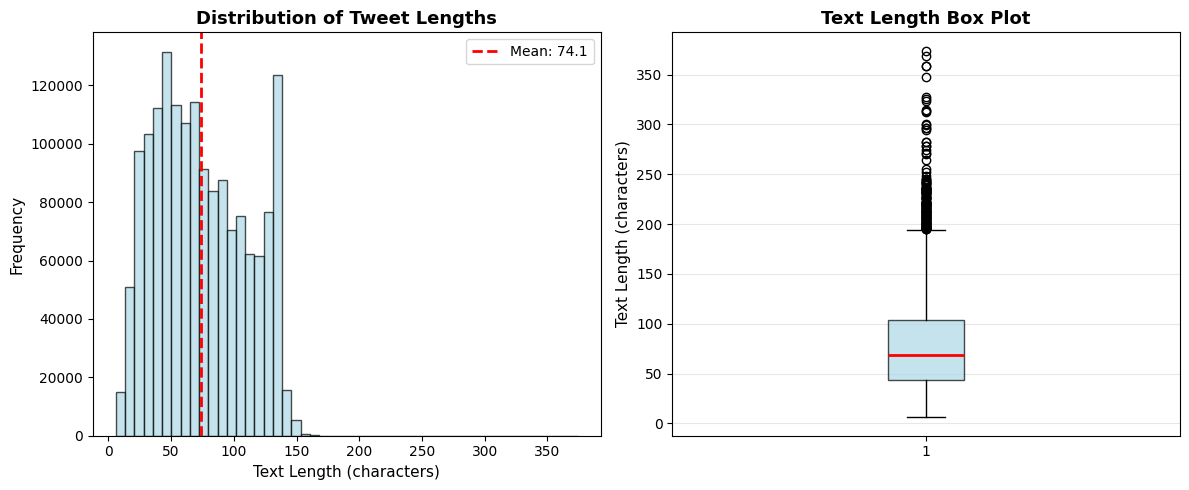

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df2['text_length'], bins=50, color='lightblue', alpha=0.7, edgecolor='black')
plt.xlabel('Text Length (characters)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Tweet Lengths', fontsize=13, fontweight='bold')
plt.axvline(df2['text_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df2["text_length"].mean():.1f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df2['text_length'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
plt.ylabel('Text Length (characters)', fontsize=11)
plt.title('Text Length Box Plot', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 2 - Balanced Sampling

Original dataset size: 1,600,000 records
Negative tweets: 800,000
Positive tweets: 800,000

Sampled 5,000 negative tweets
Sampled 5,000 positive tweets

Total balanced dataset: 10,000 records
Dataset shuffled

Labels converted: 0 (negative) → 0, 4 (positive) → 1
Balanced Dataset
sentiment
0    5000
1    5000
Name: count, dtype: int64


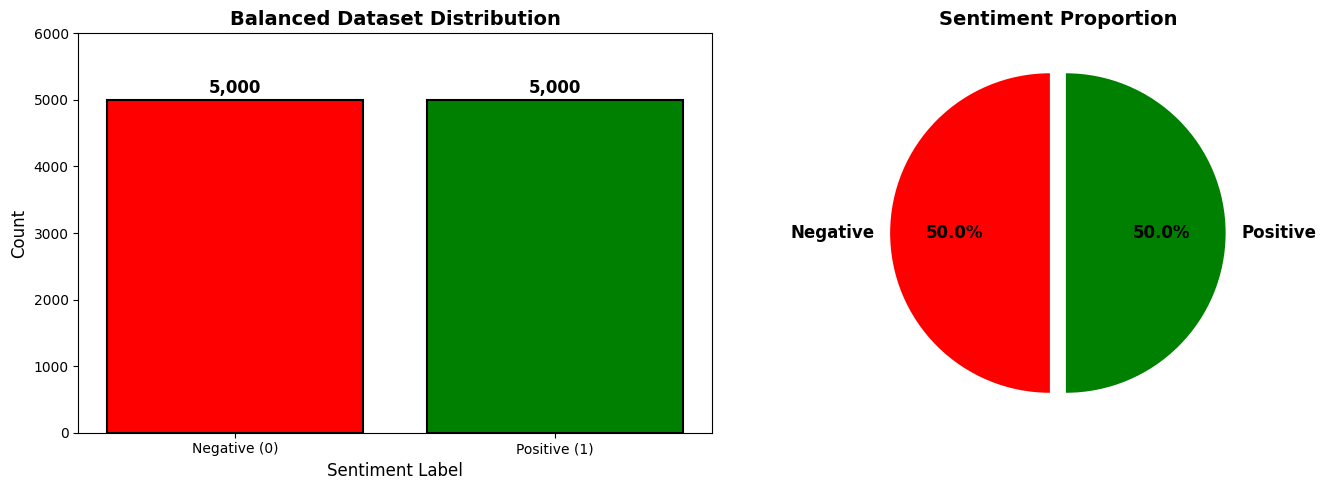

Sample Tweets From Each Class

Neg Tweets:
1. my new anti-virus ive just installed seems to be so effective, i struggle to open anything on the internet 
2. fact: i still love him...you learn from mistakes, just hope i don't repeat them again. 9 days 
3. i think i gotta make a new twitter account cuz my &quot;sojufied&quot; one is seriously all fucked up 

Pos Tweets:
1. Found the perfect title for my portfolio.  its from a song that i love 
2. @mitchelmusso LOVE the album!!  reply??
3. @basseyworld lol, no im not a &quot;logo designer person&quot; per se.. lol, but i happen to be good and everything but a pro at nothing.. 

Dataset ready: 10,000 tweets (50% negative, 50% positive)


In [45]:
print(f"Original dataset size: {len(df2):,} records")

# separate by sentiment
df_negative = df2[df2['target'] == 0]
df_positive = df2[df2['target'] == 4]

print(f"Negative tweets: {len(df_negative):,}")
print(f"Positive tweets: {len(df_positive):,}")

# sample 5K from each class
np.random.seed(42)
sample_size_per_class = 5000

df_negative_sample = df_negative.sample(n=sample_size_per_class, random_state=42)
df_positive_sample = df_positive.sample(n=sample_size_per_class, random_state=42)

print(f"\nSampled {sample_size_per_class:,} negative tweets")
print(f"Sampled {sample_size_per_class:,} positive tweets")

# Combine samples
df_balanced = pd.concat([df_negative_sample, df_positive_sample], ignore_index=True)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nTotal balanced dataset: {len(df_balanced):,} records")
print(f"Dataset shuffled")

# Convert target labels: 0: 0 (negative), 4: 1 (positive)
df_balanced['sentiment'] = df_balanced['target'].map({0: 0, 4: 1})
print(f"\nLabels converted: 0 (negative) → 0, 4 (positive) → 1")

print("Balanced Dataset")
print(df_balanced['sentiment'].value_counts().sort_index())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sentiment_counts = df_balanced['sentiment'].value_counts().sort_index()
colors = ['red', 'green']
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Sentiment Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Balanced Dataset Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negative (0)', 'Positive (1)'])
axes[0].set_ylim(0, 6000)
for i, v in enumerate(sentiment_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontsize=12, fontweight='bold')

axes[1].pie(sentiment_counts.values, labels=['Negative', 'Positive'], 
            autopct='%1.1f%%', startangle=90, colors=colors, 
            textprops={'fontsize': 12, 'fontweight': 'bold'},
            explode=(0.05, 0.05))
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Sample Tweets From Each Class")

print("\nNeg Tweets:")
for i, (idx, row) in enumerate(df_balanced[df_balanced['sentiment'] == 0].head(3).iterrows(), 1):
    print(f"{i}. {row['text']}")
    
print("\nPos Tweets:")
for i, (idx, row) in enumerate(df_balanced[df_balanced['sentiment'] == 1].head(3).iterrows(), 1):
    print(f"{i}. {row['text']}")

df_balanced = df_balanced[['text', 'sentiment']]

df_balanced.to_csv('sentiment140_balanced_10k.csv', index=False)
print(f"\nDataset ready: {len(df_balanced):,} tweets (50% negative, 50% positive)")

### 3 - Text Preprocessing

In [46]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [47]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

data = pd.read_csv('sentiment140_balanced_10k.csv')

stop_words = set(stopwords.words('english'))
print(f"Loaded {len(stop_words)} English stopwords")


def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtag symbol but keep the word
    text = re.sub(r'#', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def remove_stopwords(text):

    # Remove stopwords from text (for TF-IDF only)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)


sample_tweets = [
    "@realDonaldTrump just won the debate! #MAGA #Trump2024 https://t.co/xyz123",
    "I love this movie!!! 😊😊😊 Best ever! 10/10",
    "@user This is terrible... NOT good at all :( #sad"
]

print("\nBefore - After Preprocessing:\n")
for i, tweet in enumerate(sample_tweets, 1):
    cleaned = preprocess_text(tweet)
    print(f"{i}. ORIGINAL:")
    print(f"   {tweet}")
    print(f"   CLEANED:")
    print(f"   {cleaned}\n")


print("\npplying preprocessing to all tweets...")
data['text_cleaned'] = data['text'].apply(preprocess_text)

print("\nCreating version without stopwords (for TF-IDF)...")
data['text_cleaned_no_stopwords'] = data['text_cleaned'].apply(remove_stopwords)


print("\nPreprocessing Stats\n")

# Count empty tweets after preprocessing
empty_count = (data['text_cleaned'].str.strip() == '').sum()
print(f"\nEmpty tweets after cleaning: {empty_count}")

if empty_count > 0:
    print("Removing empty tweets...")
    data = data[data['text_cleaned'].str.strip() != ''].reset_index(drop=True)
    print(f"Dataset size after removal: {len(data):,} records")

# text len comparison
data['original_length'] = data['text'].str.len()
data['cleaned_length'] = data['text_cleaned'].str.len()
data['cleaned_no_stop_length'] = data['text_cleaned_no_stopwords'].str.len()

print("\nAverage Text Length Comparison:")
print(f"   Original:              {data['original_length'].mean():.1f} characters")
print(f"   After cleaning:        {data['cleaned_length'].mean():.1f} characters")
print(f"   Without stopwords:     {data['cleaned_no_stop_length'].mean():.1f} characters")

reduction = ((data['original_length'].mean() - data['cleaned_length'].mean()) / data['original_length'].mean()) * 100
print(f"\nLength reduction:{reduction:.1f}%")


print("\nSample Neg Tweets")
for i, (idx, row) in enumerate(data[data['sentiment'] == 0].head(3).iterrows(), 1):
    print(f"{i}. Original: {row['text'][:100]}...")
    print(f"   Cleaned:  {row['text_cleaned']}")
    print(f"   No stops: {row['text_cleaned_no_stopwords']}\n")

print("Sample Pos Tweets")
for i, (idx, row) in enumerate(data[data['sentiment'] == 1].head(3).iterrows(), 1):
    print(f"{i}. Original: {row['text'][:100]}...")
    print(f"   Cleaned:  {row['text_cleaned']}")
    print(f"   No stops: {row['text_cleaned_no_stopwords']}\n")

df_final = data[['text', 'text_cleaned', 'text_cleaned_no_stopwords', 'sentiment']]
df_final.to_csv('sentiment140_preprocessed_10k.csv', index=False)

print(f"\nDataset ready: {len(df_final):,} cleaned tweets")

Loaded 198 English stopwords

Before - After Preprocessing:

1. ORIGINAL:
   @realDonaldTrump just won the debate! #MAGA #Trump2024 https://t.co/xyz123
   CLEANED:
   just won the debate maga trump

2. ORIGINAL:
   I love this movie!!! 😊😊😊 Best ever! 10/10
   CLEANED:
   i love this movie 😊😊😊 best ever

3. ORIGINAL:
   @user This is terrible... NOT good at all :( #sad
   CLEANED:
   this is terrible not good at all sad


pplying preprocessing to all tweets...

Creating version without stopwords (for TF-IDF)...

Preprocessing Stats


Empty tweets after cleaning: 17
Removing empty tweets...
Dataset size after removal: 9,983 records

Average Text Length Comparison:
   Original:              74.5 characters
   After cleaning:        62.3 characters
   Without stopwords:     42.0 characters

Length reduction:16.4%

Sample Neg Tweets
1. Original: my new anti-virus ive just installed seems to be so effective, i struggle to open anything on the in...
   Cleaned:  my new antivirus ive just inst

### 4 - Train Test Split

In [48]:
from sklearn.model_selection import train_test_split

['text', 'text_cleaned', 'text_cleaned_no_stopwords', 'sentiment']


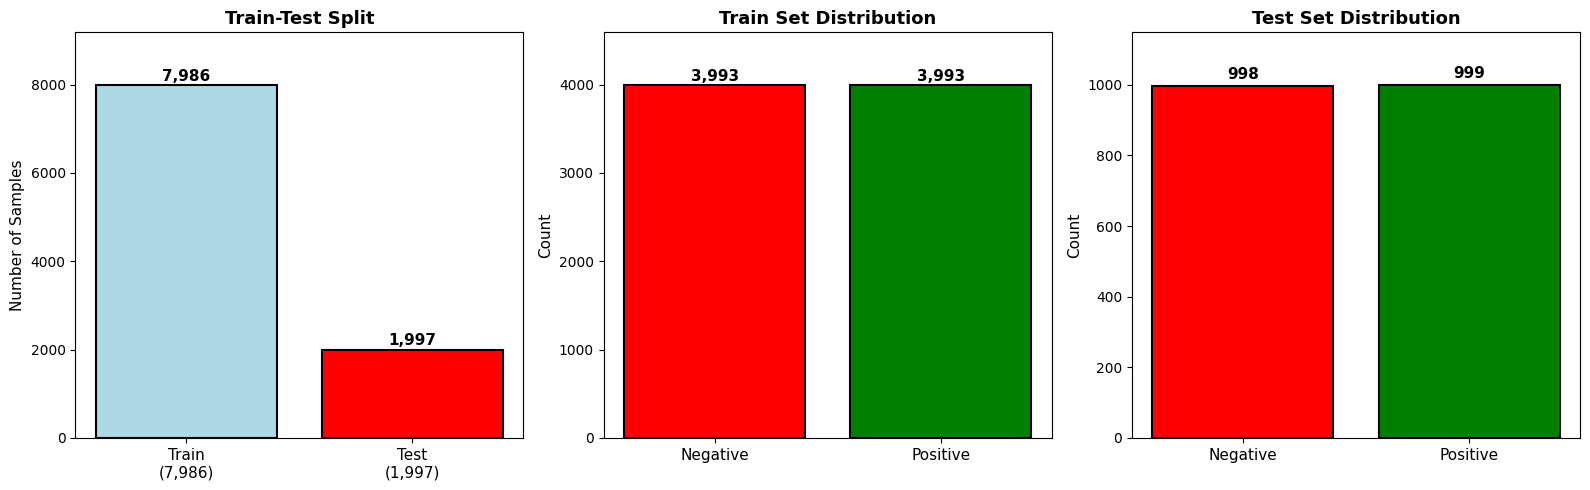

In [49]:
# Load preprocessed dataset
df = pd.read_csv('sentiment140_preprocessed_10k.csv')

print(df.columns.tolist())

test_size = 0.2
random_state = 42

X = df[['text_cleaned', 'text_cleaned_no_stopwords']]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=random_state,
    stratify=y
)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

split_sizes = [len(X_train), len(X_test)]
split_labels = [f'Train\n({len(X_train):,})', f'Test\n({len(X_test):,})']
colors_split = ['lightblue', 'red']

axes[0].bar(range(2), split_sizes, color=colors_split, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(2))
axes[0].set_xticklabels(split_labels, fontsize=11)
axes[0].set_ylabel('Number of Samples', fontsize=11)
axes[0].set_title('Train-Test Split', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, max(split_sizes) * 1.15)
for i, v in enumerate(split_sizes):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

# train distribution
train_counts = y_train.value_counts().sort_index()
colors_sent = ['red', 'green']
axes[1].bar(train_counts.index, train_counts.values, color=colors_sent, edgecolor='black', linewidth=1.5)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negative', 'Positive'], fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Train Set Distribution', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, max(train_counts.values) * 1.15)
for i, v in enumerate(train_counts.values):
    axes[1].text(i, v + 50, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

# test set distribution
test_counts = y_test.value_counts().sort_index()
axes[2].bar(test_counts.index, test_counts.values, color=colors_sent, edgecolor='black', linewidth=1.5)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Negative', 'Positive'], fontsize=11)
axes[2].set_ylabel('Count', fontsize=11)
axes[2].set_title('Test Set Distribution', fontsize=13, fontweight='bold')
axes[2].set_ylim(0, max(test_counts.values) * 1.15)
for i, v in enumerate(test_counts.values):
    axes[2].text(i, v + 20, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

train_df = pd.DataFrame({
    'text_cleaned': X_train['text_cleaned'].values,
    'text_cleaned_no_stopwords': X_train['text_cleaned_no_stopwords'].values,
    'sentiment': y_train.values
})

test_df = pd.DataFrame({
    'text_cleaned': X_test['text_cleaned'].values,
    'text_cleaned_no_stopwords': X_test['text_cleaned_no_stopwords'].values,
    'sentiment': y_test.values
})


### 5- TF-IDF + Logistic Regression

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)
import time
import pickle
from sklearn.model_selection import GridSearchCV

#### 5.1- Hyperparameter Search

In [51]:
X_train = train_df['text_cleaned_no_stopwords']  # Using version without stopwords
y_train = train_df['sentiment']
X_test = test_df['text_cleaned_no_stopwords']
y_test = test_df['sentiment']


train_nan_count = X_train.isna().sum()
test_nan_count = X_test.isna().sum()
print(f"Train NaN count: {train_nan_count}")
print(f"Test NaN count:  {test_nan_count}")

if train_nan_count > 0 or test_nan_count > 0:
    X_train = X_train.fillna('')
    X_test = X_test.fillna('')

X_train = X_train.apply(lambda x: x if x.strip() != '' else ' ')
X_test = X_test.apply(lambda x: x if x.strip() != '' else ' ')


tfidf_configs = [
    {
        'name': 'Config 1: Baseline',
        'params': {
            'max_features': 5000,
            'min_df': 2,
            'max_df': 0.8,
            'ngram_range': (1, 2),
            'sublinear_tf': True
        }
    },
    {
        'name': 'Config 2: More Features',
        'params': {
            'max_features': 8000,
            'min_df': 2,
            'max_df': 0.8,
            'ngram_range': (1, 2),
            'sublinear_tf': True
        }
    },
    {
        'name': 'Config 3: Trigrams',
        'params': {
            'max_features': 5000,
            'min_df': 2,
            'max_df': 0.8,
            'ngram_range': (1, 3),
            'sublinear_tf': True
        }
    },
    {
        'name': 'Config 4: Stricter Filtering',
        'params': {
            'max_features': 5000,
            'min_df': 5,
            'max_df': 0.7,
            'ngram_range': (1, 2),
            'sublinear_tf': True
        }
    }
]

results = []

for config in tfidf_configs:
    print(f"Testing: {config['name']}")
    print(f"  Parameters: {config['params']}")
    
    tfidf = TfidfVectorizer(**config['params'])
    
    X_train_vec = tfidf.fit_transform(X_train)
    X_test_vec = tfidf.transform(X_test)
    
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_vec, y_train)
    
    y_pred = lr.predict(X_test_vec)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'config': config['name'],
        'accuracy': acc,
        'f1_score': f1,
        'vocab_size': len(tfidf.get_feature_names_out())
    })
    
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Vocab: {len(tfidf.get_feature_names_out()):,}")
    print()

# Display results
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

best_config = results_df.loc[results_df['f1_score'].idxmax()]
print(f"\nBest Config: {best_config['config']}")
print(f"F1-Score: {best_config['f1_score']:.4f}")

Train NaN count: 35
Test NaN count:  7
Testing: Config 1: Baseline
  Parameters: {'max_features': 5000, 'min_df': 2, 'max_df': 0.8, 'ngram_range': (1, 2), 'sublinear_tf': True}
Accuracy: 0.7186 | F1: 0.7204 | Vocab: 5,000

Testing: Config 2: More Features
  Parameters: {'max_features': 8000, 'min_df': 2, 'max_df': 0.8, 'ngram_range': (1, 2), 'sublinear_tf': True}
Accuracy: 0.7181 | F1: 0.7195 | Vocab: 6,563

Testing: Config 3: Trigrams
  Parameters: {'max_features': 5000, 'min_df': 2, 'max_df': 0.8, 'ngram_range': (1, 3), 'sublinear_tf': True}
Accuracy: 0.7201 | F1: 0.7220 | Vocab: 5,000

Testing: Config 4: Stricter Filtering
  Parameters: {'max_features': 5000, 'min_df': 5, 'max_df': 0.7, 'ngram_range': (1, 2), 'sublinear_tf': True}
Accuracy: 0.7111 | F1: 0.7151 | Vocab: 1,867

                      config  accuracy  f1_score  vocab_size
          Config 1: Baseline  0.718578  0.720398        5000
     Config 2: More Features  0.718077  0.719482        6563
          Config 3: Trigram

#### 5.2- Logistic Regression with Best Parameter

In [65]:
best_tfidf = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8, 
                              ngram_range=(1, 2), sublinear_tf=True)

X_train_tfidf = best_tfidf.fit_transform(X_train)
X_test_tfidf = best_tfidf.transform(X_test)

param_grid = {
    'C': [0.1, 0.5, 1.0, 2.0, 5.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1-Score: 0.7497


In [66]:
best_model = grid_search.best_estimator_

with open('logreg_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Logistic Regression model saved as 'logreg_model.pkl'..")

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(best_tfidf, f)
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'..")

y_pred = best_model.predict(X_test_tfidf)
y_pred_proba = best_model.predict_proba(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nOptimized Model Performance:")
print(f" - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f" - Precision: {precision:.4f}")
print(f" - Recall: {recall:.4f}")
print(f" - F1-Score: {f1:.4f}")

baseline_f1 = 0.7204  # From previous step
improvement = ((f1 - baseline_f1)) * 100

print(f"\nImprovement over baseline:")
print(f" - Baseline F1: {baseline_f1:.4f}")
print(f" - Optimized F1: {f1:.4f}")
print(f" - Improvement: {improvement:+.2f}%")

Logistic Regression model saved as 'logreg_model.pkl'..
TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'..

Optimized Model Performance:
 - Accuracy: 0.7356 (73.56%)
 - Precision: 0.7320
 - Recall: 0.7437
 - F1-Score: 0.7378

Improvement over baseline:
 - Baseline F1: 0.7204
 - Optimized F1: 0.7378
 - Improvement: +1.74%


#### 5.3- Model Evaluation


Classification Report
              precision    recall  f1-score   support

    Negative     0.7393    0.7275    0.7333       998
    Positive     0.7320    0.7437    0.7378       999

    accuracy                         0.7356      1997
   macro avg     0.7357    0.7356    0.7356      1997
weighted avg     0.7357    0.7356    0.7356      1997



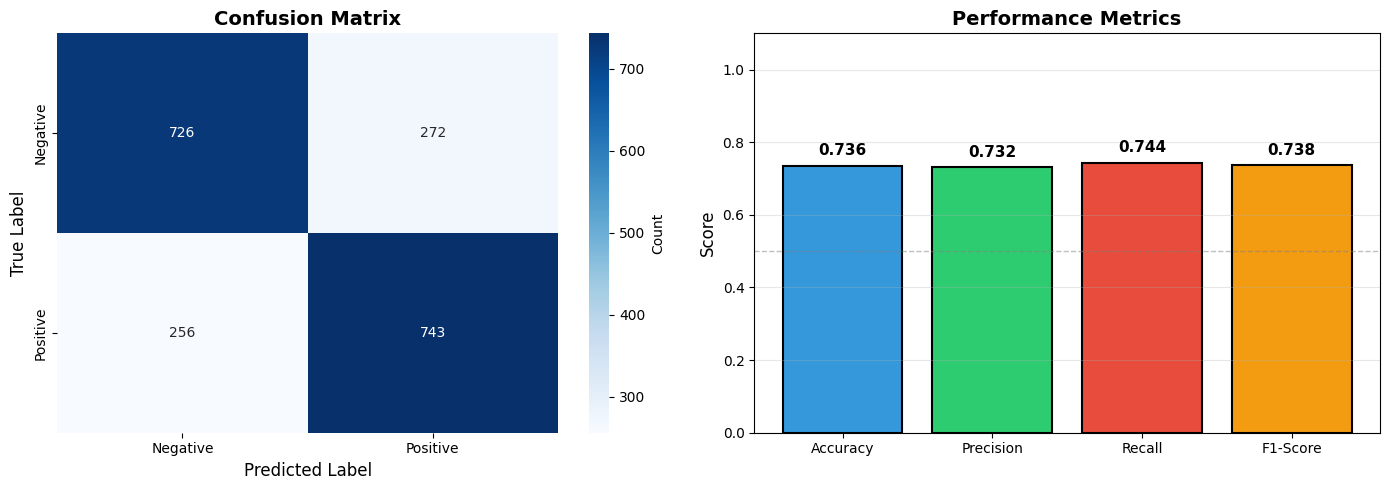


Sample Predictions
1. ❌ Text: ive huluing past several hours...
   True: Positive | Predicted: Negative (confidence: 0.810)

2. ❌ Text: want come amp visit dayi want come tuscany...
   True: Positive | Predicted: Negative (confidence: 0.673)

3. ❌ Text: ookay kinda slow actually sad cause least mtb sire yeah well...
   True: Positive | Predicted: Negative (confidence: 0.855)

4. ✅ Text: whats care wondering whats...
   True: Negative | Predicted: Negative (confidence: 0.560)

5. ✅ Text: church good service day wellll ima clean around house...
   True: Positive | Predicted: Positive (confidence: 0.635)



In [67]:
print("\nClassification Report")
print(classification_report(y_test, y_pred, 
                          target_names=['Negative', 'Positive'],
                          digits=4))

cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'],
           ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision, recall, f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = axes[1].bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Performance Metrics', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.1)
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].grid(axis='y', alpha=0.3)

for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# Display sample predictions
print("\nSample Predictions")

sample_indices = np.random.choice(len(test_df), 5, replace=False)

for i, idx in enumerate(sample_indices, 1):
    true_label = y_test.iloc[idx]
    pred_label = y_pred[idx]
    confidence = y_pred_proba[idx][pred_label]
    text = test_df.iloc[idx]['text_cleaned_no_stopwords'][:80]
    
    emoji = "✅" if true_label == pred_label else "❌"
    true_sent = "Positive" if true_label == 1 else "Negative"
    pred_sent = "Positive" if pred_label == 1 else "Negative"
    
    print(f"{i}. {emoji} Text: {text}...")
    print(f"   True: {true_sent} | Predicted: {pred_sent} (confidence: {confidence:.3f})\n")


## 6 - BERT Fine-Tuning

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import (DistilBertTokenizer, DistilBertForSequenceClassification,
                          get_linear_schedule_with_warmup)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
from tqdm import tqdm
import time
import pickle

In [56]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device: ",device)
# use text_cleaned (with stopwords for BERT)
X_train = train_df['text_cleaned'].fillna('').apply(lambda x: x if x.strip() != '' else ' ')
y_train = train_df['sentiment']
X_test = test_df['text_cleaned'].fillna('').apply(lambda x: x if x.strip() != '' else ' ')
y_test = test_df['sentiment']

print(f"Train size: {len(X_train):,}")
print(f"Test size:  {len(X_test):,}")

Device:  mps
Train size: 7,986
Test size:  1,997


#### 6.1. Tokenization

In [57]:
#DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# tokenization params
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"train loader len: {len(train_loader)}")
print(f"test loader len: {len(test_loader)}")

train loader len: 500
test loader len: 125


#### 6.2. Model Initialization

In [58]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    dropout= 0.3
)

model = model.to(device)
print(f"Model loaded and moved to device. Device: {device}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"Total: {total_params:,}")
print(f"Trainable: {trainable_params:,}")

# optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device. Device: mps

Model parameters:
Total: 66,955,010
Trainable: 66,955,010


#### 6.3. Model Training

In [60]:
# train func
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)
        
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': np.mean(losses[-10:])})
    
    return correct_predictions.float() / total_predictions, np.mean(losses)

# eval func
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)
            
            losses.append(loss.item())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.float() / total_predictions
    return accuracy, np.mean(losses), np.array(all_preds), np.array(all_labels)

# loop
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

print(f"\nStarting training for {EPOCHS} epochs..\n")

best_f1 = 0
best_epoch = 0
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_acc, val_loss, val_preds, val_labels = eval_model(model, test_loader, device)
    
    f1_tmp = f1_score(val_labels, val_preds, average= 'weighted')

    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)

    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

    if f1_tmp > best_f1:
        best_f1 = f1_tmp
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "bert_model.pt")
        print(f"Best model saved.. (Epoch {epoch+1}, F1 = {f1_tmp:.4f})")
    print("- "*15)

print(f"Training completed..")


Starting training for 3 epochs..

Epoch 1/3


Evaluating: 100%|██████████| 125/125 [00:12<00:00,  9.78it/s]



Train Loss: 0.4800, Train Acc: 0.7756
Val Loss: 0.4847, Val Acc: 0.7847

Best model saved.. (Epoch 1, F1 = 0.7833)
- - - - - - - - - - - - - - - 
Epoch 2/3


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.43it/s]



Train Loss: 0.3995, Train Acc: 0.8243
Val Loss: 0.4673, Val Acc: 0.8007

Best model saved.. (Epoch 2, F1 = 0.8005)
- - - - - - - - - - - - - - - 
Epoch 3/3


Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.35it/s]



Train Loss: 0.3493, Train Acc: 0.8491
Val Loss: 0.4988, Val Acc: 0.7997

- - - - - - - - - - - - - - - 
Training completed..


#### 6.4. Evaluation

Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.56it/s]



BERT Model Performance:
 - Accuracy: 0.8007 (80.07%)
 - Precision: 0.8214
 - Recall: 0.7688
 - F1-Score: 0.7942

Classification Report
              precision    recall  f1-score   support

    Negative     0.7825    0.8327    0.8068       998
    Positive     0.8214    0.7688    0.7942       999

    accuracy                         0.8007      1997
   macro avg     0.8019    0.8007    0.8005      1997
weighted avg     0.8019    0.8007    0.8005      1997



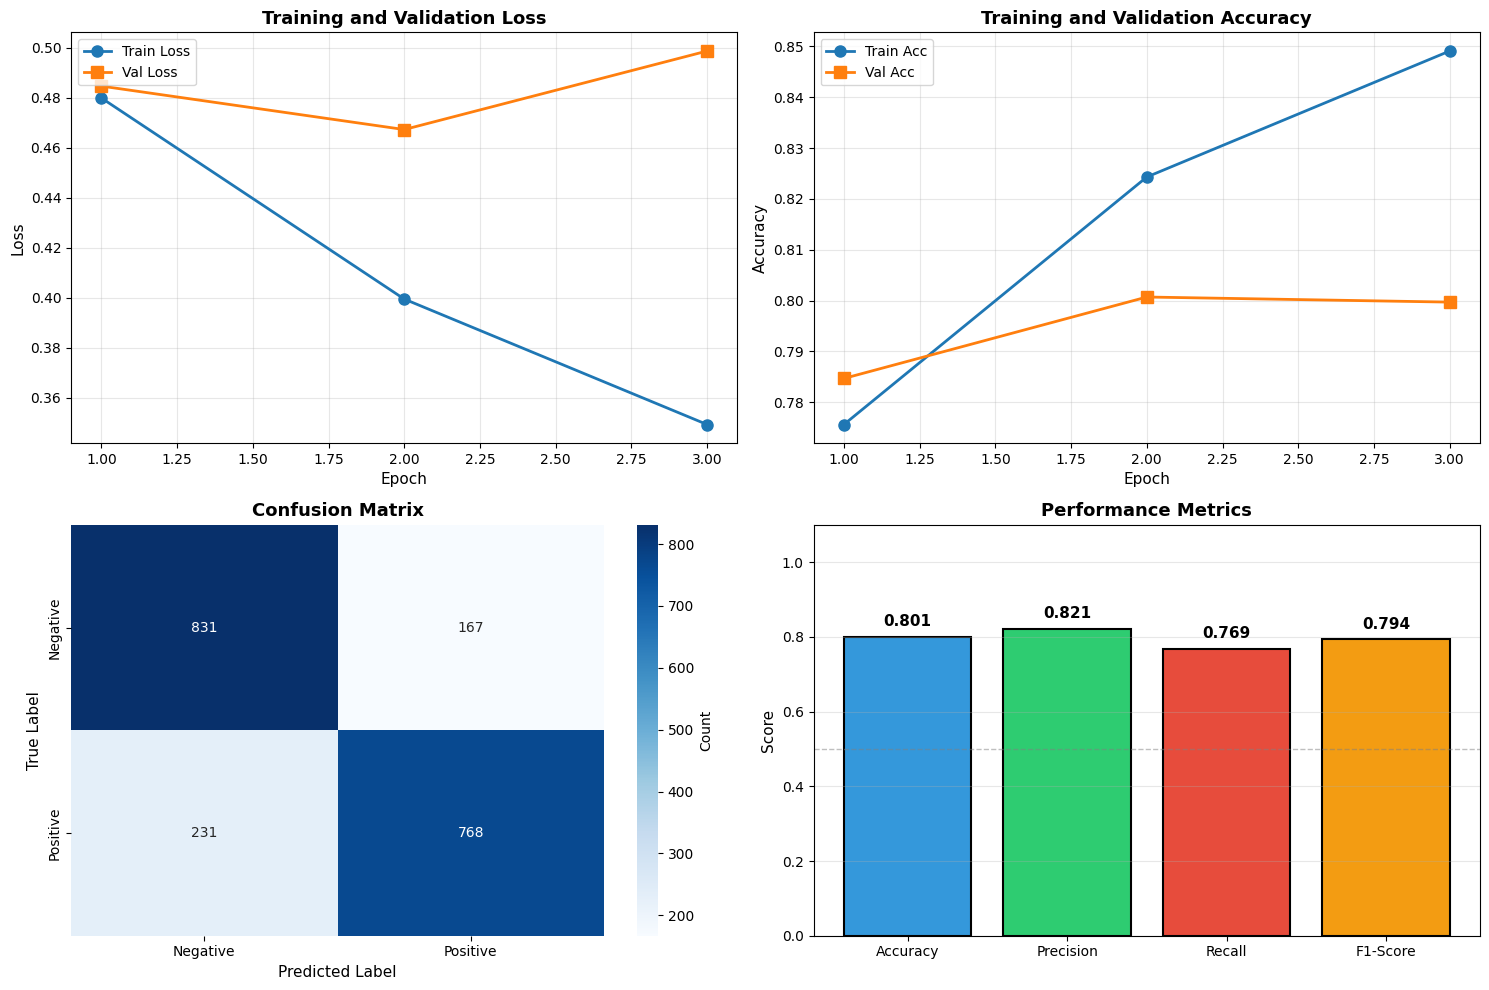

In [ ]:
model.load_state_dict(torch.load("bert_model.pt"))
_, _, y_pred, y_true = eval_model(model, test_loader, device)

# calc metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nBERT Model Performance:")
print(f" - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f" - Precision: {precision:.4f}")
print(f" - Recall: {recall:.4f}")
print(f" - F1-Score: {f1:.4f}")

print("\nClassification Report")
print(classification_report(y_true, y_pred,
                          target_names=['Negative', 'Positive'],
                          digits=4))

cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. loss
axes[0, 0].plot(range(1, EPOCHS+1), history['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=8)
axes[0, 0].plot(range(1, EPOCHS+1), history['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. accuracy
axes[0, 1].plot(range(1, EPOCHS+1), history['train_acc'], 'o-', label='Train Acc', linewidth=2, markersize=8)
axes[0, 1].plot(range(1, EPOCHS+1), history['val_acc'], 's-', label='Val Acc', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. cm
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'],
           ax=axes[1, 0], cbar_kws={'label': 'Count'})
axes[1, 0].set_xlabel('Predicted Label', fontsize=11)
axes[1, 0].set_ylabel('True Label', fontsize=11)
axes[1, 0].set_title('Confusion Matrix', fontsize=13, fontweight='bold')

# 4. metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision, recall, f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Score', fontsize=11)
axes[1, 1].set_title('Performance Metrics', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim(0, 1.1)
axes[1, 1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].grid(axis='y', alpha=0.3)

for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Test On "tweets.csv" - Model Comparison

In [62]:
tweets_df = pd.read_csv('tweets.csv')
print(f"Loaded {len(tweets_df)} tweets")

# Display sample
print("\nSample tweets:")
for i, row in tweets_df.head(3).iterrows():
    print(f"{i+1}. {row['text'][:100]}...")

Loaded 100 tweets

Sample tweets:
1. @catturd2 BREAKING NEWS: Kentucky politicians in the same political party take pictures together.  B...
2. @Military_Mantra 7 brand new fighter jets were shot down. 
Donald Trump, Indian Parliament debate 
2...
3. @simonateba That’s President Donald J Trump to you Simple Simp Simon...


#### 7.1. Preprocess

In [63]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Basic preprocessing"""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    """Remove stopwords for TF-IDF"""
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# apply preprocessing
tweets_df['text_cleaned'] = tweets_df['text'].apply(preprocess_text)
tweets_df['text_cleaned_no_stopwords'] = tweets_df['text_cleaned'].apply(remove_stopwords)

# handle empty tweets
tweets_df['text_cleaned'] = tweets_df['text_cleaned'].fillna('').apply(
    lambda x: x if x.strip() != '' else ' ')
tweets_df['text_cleaned_no_stopwords'] = tweets_df['text_cleaned_no_stopwords'].fillna('').apply(
    lambda x: x if x.strip() != '' else ' ')

#### 7.2. TF-IDF + Logistic Regression Predictions

In [68]:
print("\nLoading TF-IDF model...")
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

print("Loading Logistic Regression model...")
with open('logreg_model.pkl', 'rb') as f:
    logreg = pickle.load(f)
print("Models loaded")


X_tfidf = tfidf.transform(tweets_df['text_cleaned_no_stopwords'])
tfidf_preds = logreg.predict(X_tfidf)
tfidf_proba = logreg.predict_proba(X_tfidf)

# Add to dataframe
tweets_df['tfidf_prediction'] = tfidf_preds
tweets_df['tfidf_confidence'] = [proba[pred] for pred, proba in zip(tfidf_preds, tfidf_proba)]


Loading TF-IDF model...
Loading Logistic Regression model...
Models loaded


#### 7.3. BERT Predictions

In [69]:
print("\nLoading BERT model...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)
bert_model.load_state_dict(torch.load('best_model.pt', map_location=device))
bert_model = bert_model.to(device)
bert_model.eval()
print("BERT model loaded")

class SimpleSentimentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

bert_dataset = SimpleSentimentDataset(tweets_df['text_cleaned'], tokenizer)
bert_loader = DataLoader(bert_dataset, batch_size=16, shuffle=False)

bert_preds = []
bert_proba = []

with torch.no_grad():
    for batch in bert_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        bert_preds.extend(preds.cpu().numpy())
        bert_proba.extend(probs.cpu().numpy())

# Add to df
tweets_df['bert_prediction'] = bert_preds
tweets_df['bert_confidence'] = [proba[pred] for pred, proba in zip(bert_preds, bert_proba)]


Loading BERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded


#### 7.4. Results Analysis


Model Agreement:
 - Agreement: 60/100 (60.0%)
 - Disagreement: 40/100 (40.0%)

TF-IDF Predictions:
   Negative: 41 (41.0%)
   Positive: 59 (59.0%)

BERT Predictions:
   Negative: 69 (69.0%)
   Positive: 31 (31.0%)

Disagreement Cases (First 5)

1. Tweet: @Military_Mantra 7 brand new fighter jets were shot down. 
Donald Trump, Indian Parliament debate 
23 military sites were targeted by Pakistan. We don't want escalation with Pakistan. 
Col Sophia Indian Army
How many jets were down is not important. Why they were down in important.
CDS Chohan 🖕...
 - TF-IDF: Positive (conf: 0.669)
 - BERT:   Negative (conf: 0.934)

2. Tweet: @Resisting313392 Over 50 women came with specific stories pointing directly at Epstein and Donald J Trump DJ T is as always was guilty as hell and has been for years womanizing salting. I’ve been win by women by their general Julia committing adultery fornicating this is not complicated math. https://t.co/8zkycgLzS7...
 - TF-IDF: Positive (conf: 0.647)
 - BERT:   

/var/folders/m8/qmvcjv8d6qv1_528lmsj4st40000gn/T/ipykernel_66431/1588125130.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


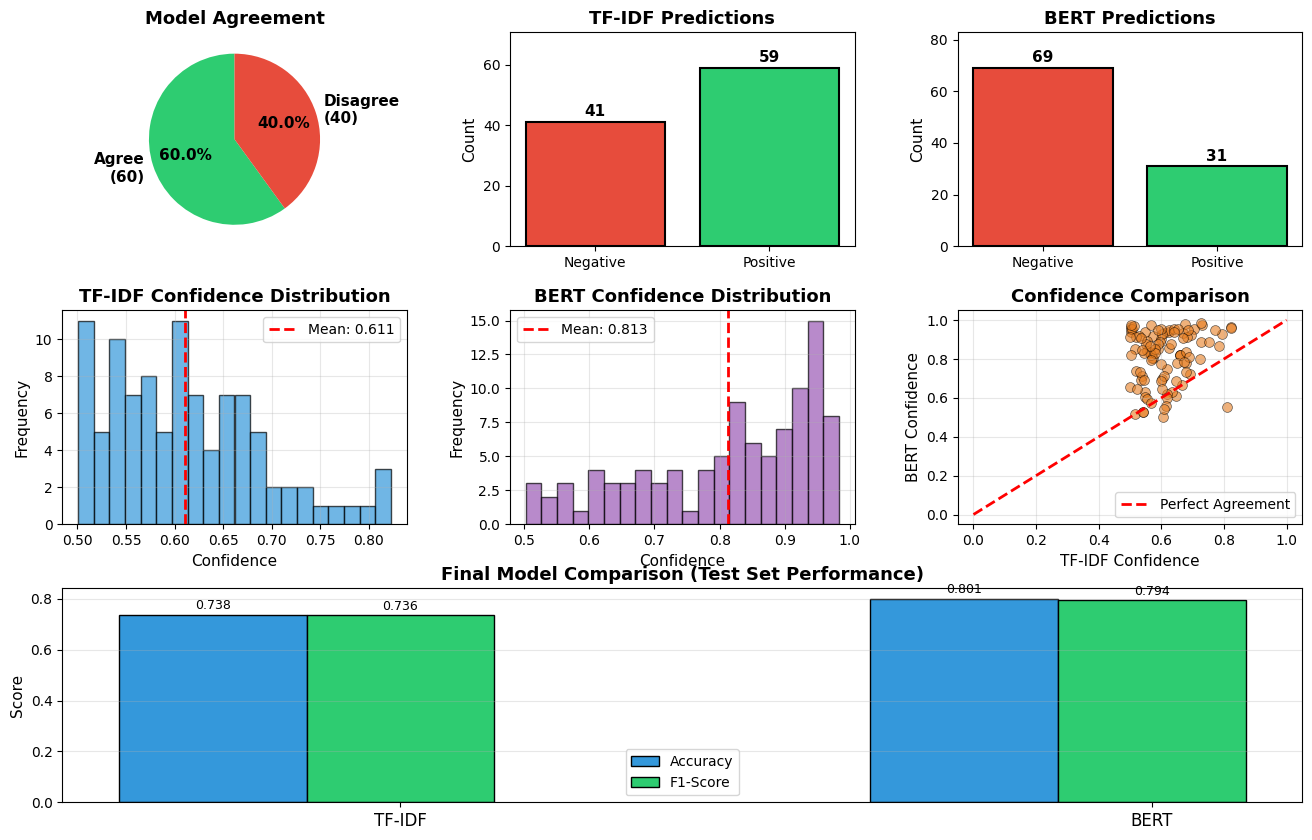

saving results to output_df..

Summary:
 - Total tweets analyzed: 100
 - Model agreement: 60.0%
 - TF-IDF avg confidence: 0.611
 - BERT avg confidence: 0.813
 - BERT improvement over TF-IDF: 5.9%


In [74]:
# agreement between models
agreement = (tweets_df['tfidf_prediction'] == tweets_df['bert_prediction']).sum()
disagreement = len(tweets_df) - agreement

print(f"\nModel Agreement:")
print(f" - Agreement: {agreement}/{len(tweets_df)} ({agreement/len(tweets_df)*100:.1f}%)")
print(f" - Disagreement: {disagreement}/{len(tweets_df)} ({disagreement/len(tweets_df)*100:.1f}%)")

# Sentiment distribution
print(f"\nTF-IDF Predictions:")
tfidf_negative = (tweets_df['tfidf_prediction'] == 0).sum()
tfidf_positive = (tweets_df['tfidf_prediction'] == 1).sum()
print(f"   Negative: {tfidf_negative} ({tfidf_negative/len(tweets_df)*100:.1f}%)")
print(f"   Positive: {tfidf_positive} ({tfidf_positive/len(tweets_df)*100:.1f}%)")

print(f"\nBERT Predictions:")
bert_negative = (tweets_df['bert_prediction'] == 0).sum()
bert_positive = (tweets_df['bert_prediction'] == 1).sum()
print(f"   Negative: {bert_negative} ({bert_negative/len(tweets_df)*100:.1f}%)")
print(f"   Positive: {bert_positive} ({bert_positive/len(tweets_df)*100:.1f}%)")

# display disagreement cases
print("\nDisagreement Cases (First 5)")
disagreements = tweets_df[tweets_df['tfidf_prediction'] != tweets_df['bert_prediction']]
if len(disagreements) > 0:
    for i, (idx, row) in enumerate(disagreements.head(10).iterrows(), 1):
        tfidf_sent = "Positive" if row['tfidf_prediction'] == 1 else "Negative"
        bert_sent = "Positive" if row['bert_prediction'] == 1 else "Negative"
        
        print(f"\n{i}. Tweet: {row['text'][:]}...")
        print(f" - TF-IDF: {tfidf_sent} (conf: {row['tfidf_confidence']:.3f})")
        print(f" - BERT:   {bert_sent} (conf: {row['bert_confidence']:.3f})")
else:
    print("\nPerfect agreement! Both models agree on all tweets.")


fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. agreement pie chart
ax1 = fig.add_subplot(gs[0, 0])
sizes = [agreement, disagreement]
labels = [f'Agree\n({agreement})', f'Disagree\n({disagreement})']
colors = ['#2ecc71', '#e74c3c']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
       textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Model Agreement', fontsize=13, fontweight='bold')

# 2. TF-IDF distr
ax2 = fig.add_subplot(gs[0, 1])
tfidf_counts = [tfidf_negative, tfidf_positive]
bars = ax2.bar(['Negative', 'Positive'], tfidf_counts, color=['#e74c3c', '#2ecc71'],
              edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('TF-IDF Predictions', fontsize=13, fontweight='bold')
ax2.set_ylim(0, max(tfidf_counts) * 1.2)
for bar, val in zip(bars, tfidf_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. BERT distr
ax3 = fig.add_subplot(gs[0, 2])
bert_counts = [bert_negative, bert_positive]
bars = ax3.bar(['Negative', 'Positive'], bert_counts, color=['#e74c3c', '#2ecc71'],
              edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('BERT Predictions', fontsize=13, fontweight='bold')
ax3.set_ylim(0, max(bert_counts) * 1.2)
for bar, val in zip(bars, bert_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. confidence - TF-IDF
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(tweets_df['tfidf_confidence'], bins=20, color='#3498db', alpha=0.7, edgecolor='black')
ax4.axvline(tweets_df['tfidf_confidence'].mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {tweets_df["tfidf_confidence"].mean():.3f}')
ax4.set_xlabel('Confidence', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('TF-IDF Confidence Distribution', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Confidence - BERT
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(tweets_df['bert_confidence'], bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
ax5.axvline(tweets_df['bert_confidence'].mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {tweets_df["bert_confidence"].mean():.3f}')
ax5.set_xlabel('Confidence', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('BERT Confidence Distribution', fontsize=13, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. confidence comparison
ax6 = fig.add_subplot(gs[1, 2])
ax6.scatter(tweets_df['tfidf_confidence'], tweets_df['bert_confidence'],
           alpha=0.6, s=50, c='#e67e22', edgecolors='black', linewidth=0.5)
ax6.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')
ax6.set_xlabel('TF-IDF Confidence', fontsize=11)
ax6.set_ylabel('BERT Confidence', fontsize=11)
ax6.set_title('Confidence Comparison', fontsize=13, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

# 7. model performance (from test set)
ax7 = fig.add_subplot(gs[2, :])
models = ['TF-IDF', 'BERT']
f1_scores = [0.7356, 0.7942]
accuracies = [0.7378, 0.8007]

x = np.arange(len(models))
width = 0.25

bars1 = ax7.bar(x - width, accuracies, width, label='Accuracy', color='#3498db', edgecolor='black')
bars2 = ax7.bar(x, f1_scores, width, label='F1-Score', color='#2ecc71', edgecolor='black')

ax7.set_ylabel('Score', fontsize=11)
ax7.set_title('Final Model Comparison (Test Set Performance)', 
             fontsize=13, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(models, fontsize=12)
ax7.legend(fontsize=10)
ax7.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# save results
print("saving results to output_df..")

output_df = tweets_df[['text', 'text_cleaned', 
                            'tfidf_prediction', 'tfidf_confidence',
                            'bert_prediction', 'bert_confidence']].copy()
output_df['tfidf_sentiment'] = output_df['tfidf_prediction'].map({0: 'Negative', 1: 'Positive'})
output_df['bert_sentiment'] = output_df['bert_prediction'].map({0: 'Negative', 1: 'Positive'})
output_df['models_agree'] = (output_df['tfidf_prediction'] == output_df['bert_prediction'])


print(f"\nSummary:")
print(f" - Total tweets analyzed: {len(tweets_df)}")
print(f" - Model agreement: {agreement/len(tweets_df)*100:.1f}%")
print(f" - TF-IDF avg confidence: {tweets_df['tfidf_confidence'].mean():.3f}")
print(f" - BERT avg confidence: {tweets_df['bert_confidence'].mean():.3f}")
print(f" - BERT improvement over TF-IDF: {((0.7942-0.7356)*100):.1f}%")